# Activations, Gradients, BatchNorm

In [1]:
# Imports
import torch
import torch.nn.functional as F

import random

import matplotlib.pyplot as plt
%matplotlib inline

In [42]:
# Hyperparaeters
block_size = 5          # Context Length! How many characters to take to predict the next one
embid_size = 15          # How many dimension in the embedding space
batch_size = 256
num_hidden = 256        # Number of neurons in the hidden layer
lr = 0.05
epochs = 5000

In [43]:
# Dataset

DATA_DIR = "../data/indian_names.txt"

train_split = 0.8
dev_split = 0.1
test_split = 0.1

assert (train_split + dev_split + test_split) == 1.0, "Data Split ration does not add up to 1.0"

# Loading data
words = open(DATA_DIR, 'r').read().splitlines()
print(len(words), "words.")

# Building Vocabulary and Conversions   str <--> int
chrs = sorted(list(set(''.join(words))))
stoi = {s : i+1 for i, s in enumerate(chrs)}
itos = {i+1 : s for i, s in enumerate(chrs)}

stoi['.'] = 0
itos[0] = '.'

special_characters = ['.']
chrs = sorted(chrs + special_characters)

# Takes some words and builds X and Y data out of it
def build_dataset(words, type = 'train'):
    
    X, Y = [], []

    for word in words:
        #print(''.join(word))
        context = [0] * block_size
        for ch in word + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(f"Shape of {type} data is     X -> {X.shape}      Y ->  {Y.shape}")

    return X, Y

# Shuffling the data
random.seed(800)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

# Calling build
Xtrain, Ytrain = build_dataset(words[:n1], "train")
Xdev, Ydev = build_dataset(words[n1:n2], "dev")
Xtest, Ytest = build_dataset(words[n2:], "test")

6474 words.
Shape of train data is     X -> torch.Size([38221, 5])      Y ->  torch.Size([38221])
Shape of dev data is     X -> torch.Size([4691, 5])      Y ->  torch.Size([4691])
Shape of test data is     X -> torch.Size([4705, 5])      Y ->  torch.Size([4705])


In [44]:
# Weights initializing
g = torch.Generator().manual_seed(800)

C = torch.randn((len(chrs), embid_size), generator=g) * 0.01

w1 = torch.randn((block_size*embid_size, num_hidden), generator=g) * 0.01
# b1 = torch.randn((num_hidden), generator=g) * 0

bngain = torch.ones((1, num_hidden))
bnbias = torch.zeros((1, num_hidden))

w2 = torch.randn((num_hidden, len(chrs)), generator=g) * 0
b2 = torch.randn(len(chrs), generator=g) * 0

parameters = [C, w1, w2, b2, bngain, bnbias]

In [45]:
# Checking parameters
for p in parameters:
    p.requires_grad = True
print("Total parameters to train -->", sum(p.nelement() for p in parameters))

Total parameters to train --> 27056


In [46]:
# Accumulation storage
loss_track = []
lr_track = []

bn_running_mean = torch.zeros(1, num_hidden)
bn_running_std = torch.zeros((1, num_hidden))

lre = torch.linspace(-3, 0, epochs)
lrs = 10**lre

In [47]:
# Training Loop

for epoch in range(epochs):

    # Batch creation
    ix = torch.randint(0, Xtrain.shape[0], (batch_size,))

    # Forward Pass
    emb = C[Xtrain[ix]]      # Shape [batch_dim, block_dim, emb_dim]
    emb_cat = emb.view((-1, emb.shape[1]*emb.shape[2]))
    hpreact = emb_cat @ w1 # + b1

    # batchnorm
    bnmean = hpreact.mean(0, keepdim = True)
    bnstd = hpreact.std(0, keepdim = True)
    hpreact = (bngain * (hpreact - bnmean) / bnstd) + bnbias
    # Running bn values
    with torch.no_grad():
        bn_running_mean = 0.999 * bn_running_mean + 0.001 * bnmean
        bn_running_std = 0.999 * bn_running_std + 0.001 * bnstd
        
    h = torch.tanh(hpreact)
    logits = h @ w2 + b2            # Shape [batch_size, vocab]
    loss = F.cross_entropy(logits, Ytrain[ix])

    # Backward Pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    # lr = lrs[epoch]
    lr = 0.01
    for p in parameters:
        p.data -= lr * p.grad

    # Statistics
    if epoch % 10000 == 0:
        print(f'{epoch=} and {loss.item()=}')

    # Accumulate
    loss_track.append(loss.log10().item())
    lr_track.append(lr)

epoch=0 and loss.item()=3.295837163925171


In [48]:
# Testing loss on a dataset
@torch.no_grad()
def split_loss(split):
    xs, ys = {
        'train' : (Xtrain, Ytrain),
        'dev' : (Xdev, Ydev),
        'test' : (Xtest, Ytest)
    }[split]

    # Forward Pass
    emb = C[xs]      # Shape [batch_dim, block_dim, emb_dim]
    emb_cat = emb.view((-1, emb.shape[1]*emb.shape[2]))
    hpreact = emb_cat @ w1
    hpreact = (bngain * (hpreact - bn_running_mean) / bn_running_std) + bnbias
    h = torch.tanh(hpreact)
    logits = h @ w2 + b2            # Shape [batch_size, vocab]
    loss = F.cross_entropy(logits, ys)

    print(f"{split} loss        ->      {loss.item()}")

split_loss('train')
split_loss('dev')

train loss        ->      2.0161242485046387
dev loss        ->      2.082033634185791


In [118]:
'''
Logging Loss
__________________________________________________
After weights to small number and tanh saturation 
train loss        ->      2.0356791019439697
dev loss        ->      2.077951192855835
__________________________________________________
After adding Batch Normalization
train loss        ->      1.3566476106643677
dev loss        ->      2.3580377101898193

'''

'\nLogging Loss\n__________________________________________________\nAfter weights to small number and tanh saturation \ntrain loss        ->      2.0356791019439697\ndev loss        ->      2.077951192855835\n__________________________________________________\n\n\n\n'

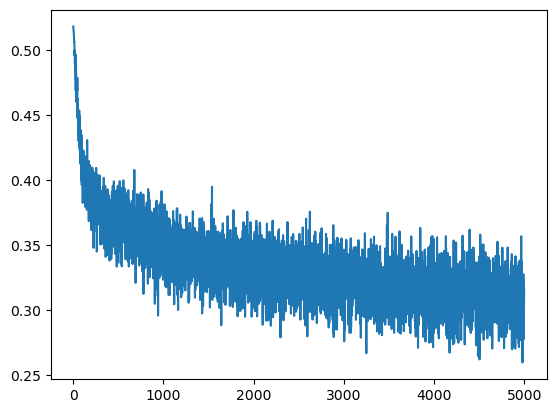

In [49]:
# Plotting the loss vs epochs
plt.plot(range(len(loss_track)), loss_track)

In [17]:
# Sample from the model
g = torch.Generator().manual_seed(700)

num_names = 20
names = []

for i in range(num_names):

    name = ""
    context = [0] * block_size

    while True:
        # forward pass
        emb = C[torch.tensor([context])]        # [1, block_size, emb_size]
        emb_cat = emb.view((-1, emb.shape[1]*emb.shape[2]))
        hpreact = emb_cat @ w1 # + b1
        hpreact = (bngain * (hpreact - bn_running_mean) / bn_running_std) + bnbias
        h = torch.tanh(hpreact)
        logits = h @ w2 + b2            # Shape [batch_size, vocab]
        probs = F.softmax(logits, dim = 1)
        # sample from this dist
        ix = torch.multinomial(probs, num_samples = 1, replacement = True, generator=g).item()
        context = context[1:] + [ix]
        # break and save because end of word
        if itos[ix] == '.':
            names.append(name)
            break
        # store characters
        name = name + itos[ix]

names

['manrbhit',
 'bharmany',
 'boduram',
 'firoshanaj',
 'kanfiya',
 'budhra',
 'duru',
 'riyazuddin',
 'mehnaz',
 'shana',
 'sawer',
 'dhmene',
 'nanda',
 'badrudeen',
 'sharadhana',
 'shivbhi',
 'litu',
 'hambudeen',
 'rashida',
 'bhim']

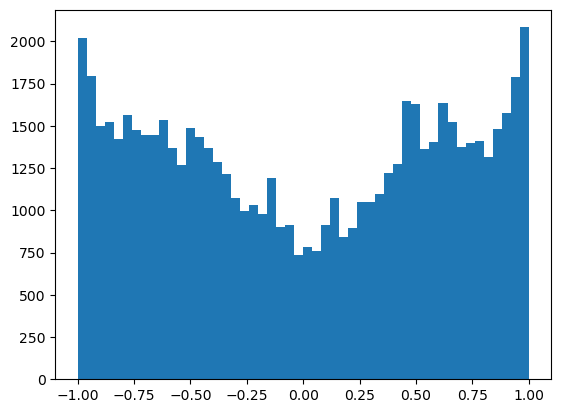

In [52]:
# Figuring out tanh
plt.hist(h.view(-1).tolist(), 50);

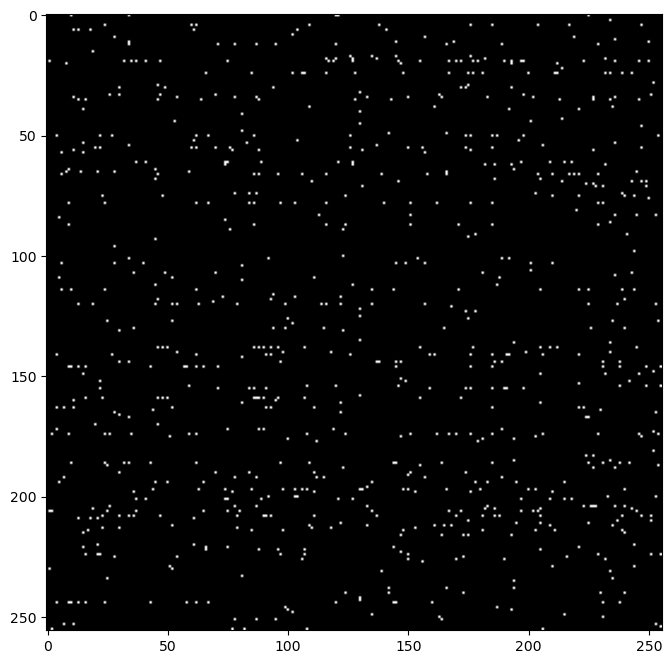

In [53]:
plt.figure(figsize = (8,8))
plt.imshow(h.abs() > 0.99, cmap = 'gray');

In [16]:
logits

tensor([[-1.0297, -4.8991, -0.6347,  ..., -2.4983, -3.1881,  2.1406],
        [-5.0404,  2.3415, -1.1482,  ..., -3.7047, -0.6870,  0.5098],
        [-2.6160, -2.0117, -2.4478,  ..., -2.1187,  1.2871, -0.6279],
        ...,
        [-1.9238,  1.4701,  1.8079,  ..., -1.1708,  1.8764, -1.4197],
        [-8.2191, -1.4616,  1.0585,  ..., -3.6768,  1.2324,  2.7260],
        [-8.3481, -0.4978,  0.3207,  ..., -2.1820,  2.1389,  0.0515]],
       grad_fn=<AddBackward0>)

# Torch-ifying the Code

In [2]:
# Imports
import torch
import torch.nn.functional as F

import random
from typing import Any

import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
# Dataset

DATA_DIR = "../data/indian_names.txt"

train_split = 0.8
dev_split = 0.1
test_split = 0.1

assert (train_split + dev_split + test_split) == 1.0, "Data Split ration does not add up to 1.0"

# Loading data
words = open(DATA_DIR, 'r').read().splitlines()
print(len(words), "words.")

# Building Vocabulary and Conversions   str <--> int
chrs = sorted(list(set(''.join(words))))
stoi = {s : i+1 for i, s in enumerate(chrs)}
itos = {i+1 : s for i, s in enumerate(chrs)}

stoi['.'] = 0
itos[0] = '.'

special_characters = ['.']
chrs = sorted(chrs + special_characters)

# Takes some words and builds X and Y data out of it
def build_dataset(words, type = 'train'):
    
    X, Y = [], []

    for word in words:
        #print(''.join(word))
        context = [0] * block_size
        for ch in word + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(f"Shape of {type} data is     X -> {X.shape}      Y ->  {Y.shape}")

    return X, Y

# Shuffling the data
random.seed(800)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

# Calling build
Xtrain, Ytrain = build_dataset(words[:n1], "train")
Xdev, Ydev = build_dataset(words[n1:n2], "dev")
Xtest, Ytest = build_dataset(words[n2:], "test")

6474 words.
Shape of train data is     X -> torch.Size([38221, 5])      Y ->  torch.Size([38221])
Shape of dev data is     X -> torch.Size([4691, 5])      Y ->  torch.Size([4691])
Shape of test data is     X -> torch.Size([4705, 5])      Y ->  torch.Size([4705])


In [13]:
class Linear:

    def __init__(self, fan_in, fan_out, bias = True) -> None:
        self.weights = torch.randn(fan_in, fan_out) / fan_in**0.5
        self.bias = None
        if bias:
            self.bias = torch.zeros(fan_out)

    def __call__(self, *args: Any, **kwds: Any) -> Any:
        x = args[0]
        self.out = x @ self.weights
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):

        if self.bias is not None:
            return [self.weights] + [self.bias]
        else:
            return [self.weights]
        
class BatchNorm1d:

    def __init__(self, dim, eps = 1e-5, momentum = 0.1) -> None:
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # Batch Norm weights
        self.aplha = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # Buffer weights
        self.running_mean = torch.ones(dim)
        self.running_var = torch.zeros(dim)

    def __call__(self, *args: Any, **kwds: Any) -> Any:
        x = args[0]
        # Find mean and var
        if self.training:
            xmean = x.mean(0, keepdim = True)
            xvar = x.var(0, keepdim = True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        # Calculate output
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = (self.aplha * xhat) + self.beta
        # Update the buffers
        if self.training:
            self.running_mean = (1 - self.momentum) * self.running_mean + (self.momentum * xmean)
            self.running_var = (1 - self.momentum) * self.running_var + (self.momentum * xvar)
        # Return the output
        return self.out
    
    def parameters(self):
        return [self.aplha, self.beta]
    
class Tanh:

    def __init__(self) -> None:
        pass

    def __call__(self, *args: Any, **kwds: Any) -> Any:
        x = args[0]
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

In [59]:
# Visualize activations and gradients
def visualize_act_or_grad(layers, act_grad = "act"):

    plt.figure(figsize = (20, 4))
    legends = []

    for i, layer in enumerate(layers[0:-1]):
        if isinstance(layer, Tanh):
            try:
                if act_grad == 'act':
                    t = layer.out
                elif act_grad == 'grad':
                    t = layer.out.grad
            except Exception as e:
                print(f"Having act_grad as {act_grad} is not allowed. {e}")
            print(f"Layer {i}   |   Type {layer.__class__.__name__}    |   Mean {t.mean()}  |   Std {t.std()}   |   Saturation {(t.abs() > 0.97).float().mean()*100}%")
            hy, hx = torch.histogram(t, density = True)
            plt.plot(hx[:-1].detach(), hy.detach())
            legends.append(f"Layer {i}")

    plt.legend(legends)
    if act_grad == 'act':
        plt.title("Activations Distribution")
    else:
        plt.title("Gradient Distribution")

    plt.show()

In [84]:
# Hyperparaeters
block_size = 5          # Context Length! How many characters to take to predict the next one
embid_size = 15          # How many dimension in the embedding space
batch_size = 256
num_hidden = 256        # Number of neurons in the hidden layer
num_outputs = 27
lr = 0.05
loss_track = []
epochs = 800

In [90]:
# Building Network
g = torch.Generator().manual_seed(800)

# Embeddigs matrix
C = torch.randn((len(chrs), embid_size), generator=g)

# Initializing all the layers
layers = [Linear(   block_size * embid_size, num_hidden), BatchNorm1d(num_hidden), Tanh(),
          Linear(               num_hidden, num_hidden), BatchNorm1d(num_hidden), Tanh(),
          Linear(               num_hidden, num_hidden), BatchNorm1d(num_hidden), Tanh(),
          Linear(               num_hidden, num_hidden), BatchNorm1d(num_hidden), Tanh(),
          Linear(               num_hidden, num_hidden), BatchNorm1d(num_hidden), Tanh(),
          Linear(             num_hidden, num_outputs), BatchNorm1d(num_outputs)]

# Apply gains to layers
with torch.no_grad():
    # Low confidence softmax
    layers[-1].aplha *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            # Kaiming Initializer
            layer.weights *= (5/3)

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(f"Total parameters to train --> {sum(p.nelement() for p in parameters)}")
for p in parameters:
    p.requires_grad = True

Total parameters to train --> 292582


In [91]:
# Training Loop

for epoch in range(epochs):

    # Batch creation
    ix = torch.randint(0, Xtrain.shape[0], (batch_size,))
    Xb = Xtrain[ix]
    Yb = Ytrain[ix]

    # Forward Pass
    emb = C[Xb]    # [#batch_size, #block_size, #embid_size]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # Backward Pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    lr = 0.05 if epoch < 5000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad

    # Statistics
    if epoch % 1000 == 0:
        print(f'{epoch=} and {loss.item()=}')

    # Accumulate
    loss_track.append(loss.log10().item())

    break

epoch=0 and loss.item()=3.290802001953125


Layer 2   |   Type Tanh    |   Mean 0.0007408774690702558  |   Std 0.6218607425689697   |   Saturation 3.9825439453125%
Layer 5   |   Type Tanh    |   Mean 0.0019029290415346622  |   Std 0.6293335556983948   |   Saturation 3.58734130859375%
Layer 8   |   Type Tanh    |   Mean -0.0030474867671728134  |   Std 0.6338496208190918   |   Saturation 3.27606201171875%
Layer 11   |   Type Tanh    |   Mean -0.0006640043575316668  |   Std 0.6323041915893555   |   Saturation 3.240966796875%
Layer 14   |   Type Tanh    |   Mean -0.0004329006187617779  |   Std 0.6348880529403687   |   Saturation 3.16925048828125%


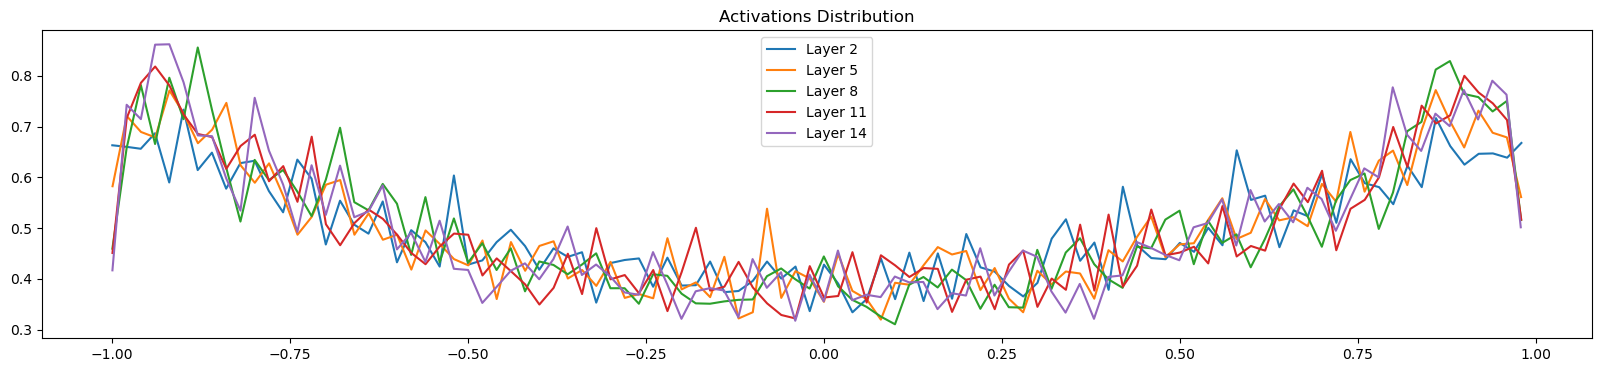

Layer 2   |   Type Tanh    |   Mean -7.105427357601002e-14  |   Std 6.210077845025808e-05   |   Saturation 0.0%
Layer 5   |   Type Tanh    |   Mean -2.4868995751603507e-14  |   Std 5.408363358583301e-05   |   Saturation 0.0%
Layer 8   |   Type Tanh    |   Mean -1.1368683772161603e-13  |   Std 4.8497331590624526e-05   |   Saturation 0.0%
Layer 11   |   Type Tanh    |   Mean -8.526512829121202e-14  |   Std 4.2641302570700645e-05   |   Saturation 0.0%
Layer 14   |   Type Tanh    |   Mean -1.2434497875801753e-13  |   Std 3.908513826900162e-05   |   Saturation 0.0%


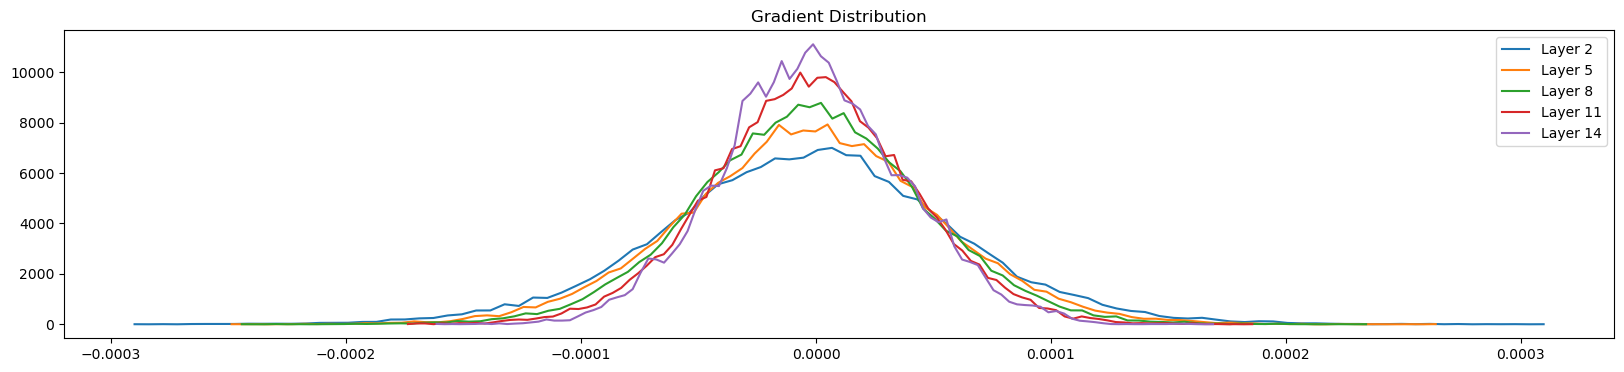

In [92]:
visualize_act_or_grad(layers, 'act')
visualize_act_or_grad(layers, 'grad')